In [1]:
# Copyright 2024 L3Harris Technologies, Inc.
#
#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at
#
#        http://www.apache.org/licenses/LICENSE-2.0
#
#    Unless required by applicable law or agreed to in writing, software
#    distributed under the License is distributed on an "AS IS" BASIS,
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#    See the License for the specific language governing permissions and
#    limitations under the License.
#

In [2]:
import numpy as np 
import sympy
from copy import deepcopy
import time


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [3]:
# only one grid point for this analysis.
n = 1
x = 0 # index of the one and only grid node x is zero.
Q = 27
nQ = n*Q



In [4]:

F_1_matrix_name = "F_1_matrix"
F_2_matrix_name = "F_2_matrix"
F_3_matrix_name = "F_3_matrix"
F_matrix_var_names = [F_1_matrix_name, F_2_matrix_name, F_3_matrix_name]



def print_matrix_info(matrix_name, return_val: bool=False):
    A = globals()[matrix_name]

    num_nonzero_elements = np.count_nonzero(A)
    num_unique_elements = len(np.unique(A)) - 1 # minus 1 because not including zero!

    description = (f"{matrix_name}, shape={A.shape}, rank={np.linalg.matrix_rank(A)}, num_nonzero={num_nonzero_elements}, num_unique_nonzero={num_unique_elements}")
    if return_val:
        return description
    else: 
        print(description)



In [5]:
# Define lexicographical index sort functions per Appendix on variable indexing.
def lexi_x(x):
    # equation 71
    # This one is simple because we only have one grid point in this analysis.
    return x

def lexi_1(i, x_beta, Q: int=27):
    # equation 73
    return Q*lexi_x(x_beta) + i

def lexi_2(j,k,x_beta,x_gamma, n: int=1, Q: int=27):
    # equation 76
    return Q**2*(n*lexi_x(x_beta) + lexi_x(x_gamma)) + Q*j + k

def lexi_3(j,k,ell,x_beta,x_gamma,x_delta, n: int=1, Q: int=27):
    # equation 78:
    return Q**3*(n**2*lexi_x(x_beta) + n*lexi_x(x_gamma) + lexi_x(x_delta)) + Q**2*j + Q*k + ell

In [6]:

# Lattice Boltzmann Method: Principles and Practice (Book), Page 90
D3Q27_weights = np.zeros(Q, dtype=float)
# D3Q27_weights = np.ones(Q, dtype=float) # F1 is symmetric if the weights are uniform.


D3Q27_weights[0] = 8.0/27
D3Q27_weights[1:7] = 2.0/27
D3Q27_weights[7:19] = 1.0/54
D3Q27_weights[19:] = 1.0/216


# Lattice Boltzmann Method: Principles and Practice (Book), Page 90
D3Q27_vectors = np.zeros((Q,3), dtype=int)
D3Q27_vectors[0:] = [ 0,  0,  0] # 0
D3Q27_vectors[1:] = [ 1,  0,  0] # 1
D3Q27_vectors[2:] = [-1,  0,  0]
D3Q27_vectors[3:] = [ 0,  1,  0]
D3Q27_vectors[4:] = [ 0, -1,  0]
D3Q27_vectors[5:] = [ 0,  0,  1]
D3Q27_vectors[6:] = [ 0,  0, -1] # 6
D3Q27_vectors[7:] = [ 1,  1,  0] # 7
D3Q27_vectors[8:] = [-1, -1,  0]
D3Q27_vectors[9:] = [ 1,  0,  1]
D3Q27_vectors[10:] = [-1,  0, -1]
D3Q27_vectors[11:] = [ 0,  1,  1]
D3Q27_vectors[12:] = [ 0, -1, -1]
D3Q27_vectors[13:] = [ 1, -1,  0]
D3Q27_vectors[14:] = [-1,  1,  0]
D3Q27_vectors[15:] = [ 1,  0, -1]
D3Q27_vectors[16:] = [-1,  0,  1]
D3Q27_vectors[17:] = [ 0,  1, -1]
D3Q27_vectors[18:] = [ 0, -1,  1] # 18
D3Q27_vectors[19:] = [ 1,  1,  1] # 19
D3Q27_vectors[20:] = [-1, -1, -1]
D3Q27_vectors[21:] = [ 1,  1, -1]
D3Q27_vectors[22:] = [-1, -1,  1]
D3Q27_vectors[23:] = [ 1, -1,  1]
D3Q27_vectors[24:] = [-1,  1, -1]
D3Q27_vectors[25:] = [-1,  1,  1]
D3Q27_vectors[26:] = [ 1, -1, -1]


c = deepcopy(D3Q27_vectors)
w = deepcopy(D3Q27_weights)






In [7]:
F_1_matrix = np.zeros((Q,Q))
F_2_matrix = np.zeros((Q,Q*Q))
F_3_matrix = np.zeros((Q,Q*Q*Q))



start_time = time.time()

for i in range(Q):

    # Formulas for T_ per Section "Appendix: Derivation of Functions to Compute S- and F-Matrix Elements"
    T_0_1 = 0.0         # equation 82
    T_1_1 = 0.0         # equation 83
    T_2_1 = 0.0         # equation 84
    T_3_2_dense = 0.0   # equation 88
    T_4_2_dense = 0.0   # equation 95
    T_3_3_dense = 0.0   # equation 91
    T_4_3_dense = 0.0   # equation 98

    for j in range(Q):

        T_0_1 = -1.0*float(i == j)
        T_1_1 = w[i]
        T_2_1 = 3*w[i]*np.inner(c[i],c[j])
        
        F_1_matrix[i,j] = T_0_1 + T_1_1 + T_2_1


        for k in range(Q):
            
            T_3_2_dense = 9*w[i]*np.inner(c[i],c[j])*np.inner(c[i],c[k])
            T_4_2_dense = -3*w[i]*np.inner(c[j],c[k])

            F_2_matrix[i,lexi_2(k,j,x,x)] = T_3_2_dense + T_4_2_dense

            for ell in range(Q):
                
                T_3_3_dense = (-9.0*w[i]/2.0)*np.inner(c[i],c[k])*np.inner(c[i],c[ell])
                
                # The original manuscript had a (-1) sign error in (86), the formula 
                # for the T_4_3_dense term.  This has been corrected in the manuscript.
                # This Python script was corrected by JohnP on 16-Sep 2024.
                # T_4_3_dense = (-3.0*w[i]/2.0)*np.inner(c[k],c[ell]) # <---- incorrect/old.
                T_4_3_dense = (3.0*w[i]/2.0)*np.inner(c[k],c[ell]) # <---- fixed.

                F_3_matrix[i,lexi_3(j,k,ell,x,x,x)] = T_3_3_dense + T_4_3_dense



end_time = time.time()
elapsed_time = end_time - start_time
print("done.")
print(f"Elapsed time: {elapsed_time:.2f} seconds")


print("WARNING!!!  These matrices have not been scaled by the tau parameter yet!")
print_matrix_info(matrix_name="F_1_matrix")
print_matrix_info(matrix_name="F_2_matrix")
print_matrix_info(matrix_name="F_3_matrix")


done.
Elapsed time: 4.29 seconds
WARNING!!!  These matrices have not been scaled by the tau parameter yet!
F_1_matrix, shape=(27, 27), rank=23, num_nonzero=729, num_unique_nonzero=13
F_2_matrix, shape=(27, 729), rank=6, num_nonzero=15180, num_unique_nonzero=42
F_3_matrix, shape=(27, 19683), rank=6, num_nonzero=409860, num_unique_nonzero=42


In [8]:
# write out matrices for posterity or to skip previous cells.

np.savez_compressed("F_1_matrix.npz", F_1_matrix=F_1_matrix)
np.savez_compressed("F_2_matrix.npz", F_2_matrix=F_2_matrix)
np.savez_compressed("F_3_matrix.npz", F_3_matrix=F_3_matrix)
print("WARNING!!!  These matrices have not been scaled by the tau parameter yet!")

WARNING!!!  These matrices have not been scaled by the tau parameter yet!


In [9]:
# read in matrices.

F_1_matrix = np.load("F_1_matrix.npz")["F_1_matrix"]
F_2_matrix = np.load("F_2_matrix.npz")["F_2_matrix"]
F_3_matrix = np.load("F_3_matrix.npz")["F_3_matrix"]

print("WARNING!!!  These matrices have not been scaled by the tau parameter yet!")
print_matrix_info(matrix_name="F_1_matrix")
print_matrix_info(matrix_name="F_2_matrix")
print_matrix_info(matrix_name="F_3_matrix")

WARNING!!!  These matrices have not been scaled by the tau parameter yet!
F_1_matrix, shape=(27, 27), rank=23, num_nonzero=729, num_unique_nonzero=13
F_2_matrix, shape=(27, 729), rank=6, num_nonzero=15180, num_unique_nonzero=42
F_3_matrix, shape=(27, 19683), rank=6, num_nonzero=409860, num_unique_nonzero=42


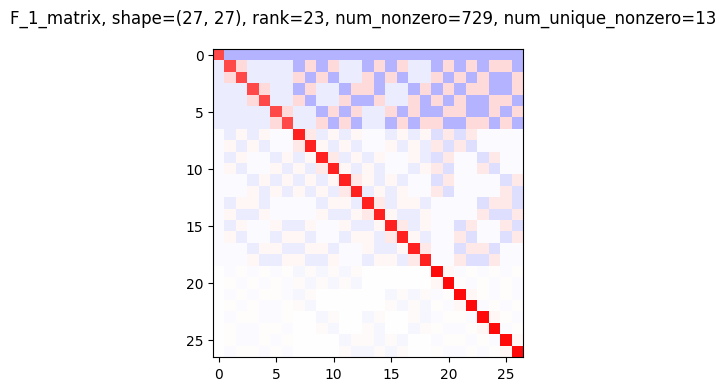

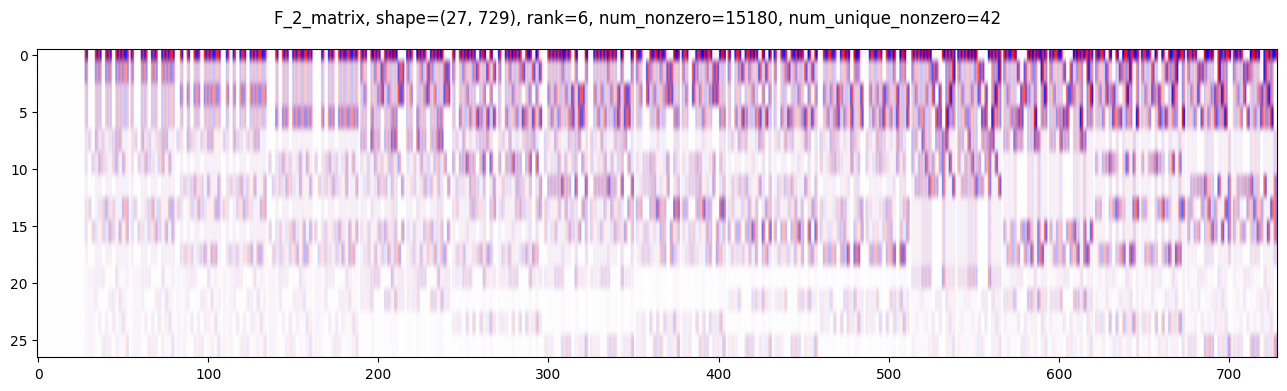

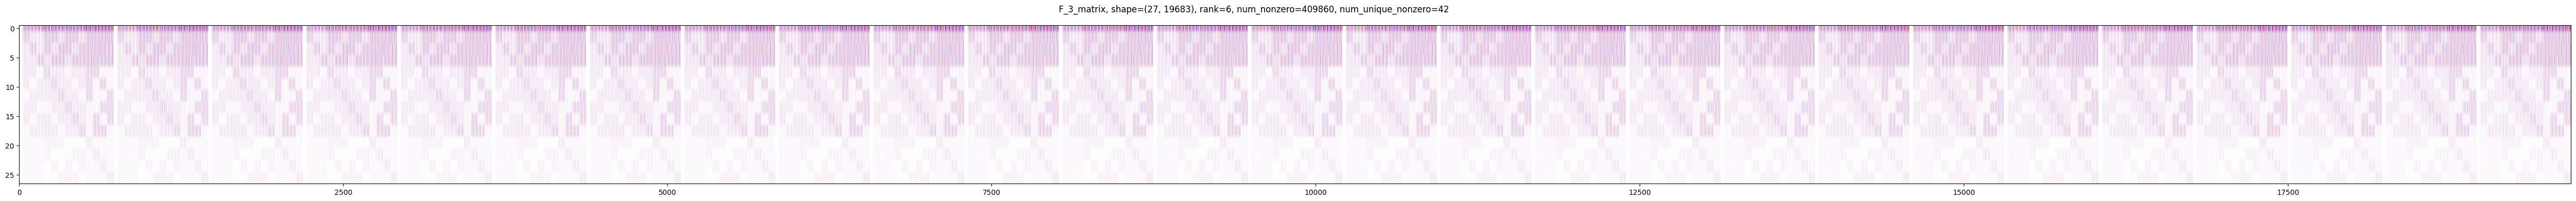

In [10]:
cmap = mcolors.LinearSegmentedColormap.from_list(
    "red_white_blue", ["red", "white", "blue"]
)
cmap_norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)


for F_matrix_name in F_matrix_var_names:
    
    if F_matrix_name == "F_1_matrix":
        figsize = (4,4)
    if F_matrix_name == "F_2_matrix":
        figsize = (16,4)
    if F_matrix_name == "F_3_matrix":
        figsize = (64,4)

    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(
        locals()[F_matrix_name],
        aspect="auto",
        cmap=cmap,
        norm=cmap_norm
    )
    fig.suptitle(print_matrix_info(F_matrix_name, return_val=True))
    fig.savefig(f"{F_matrix_name}.png", dpi=300)
    plt.show()
    plt.close(fig)


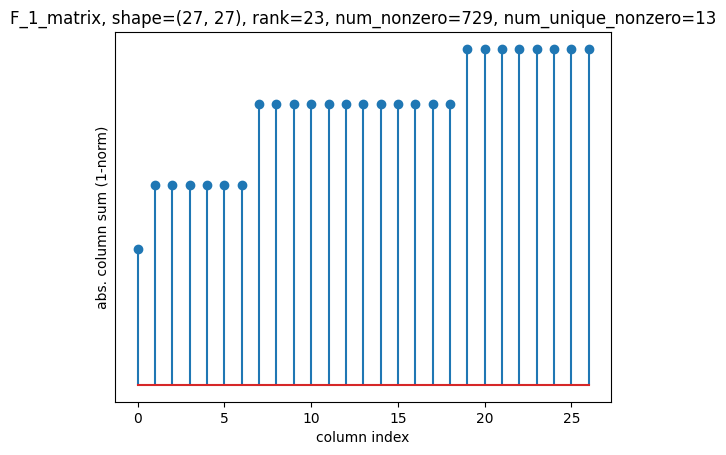

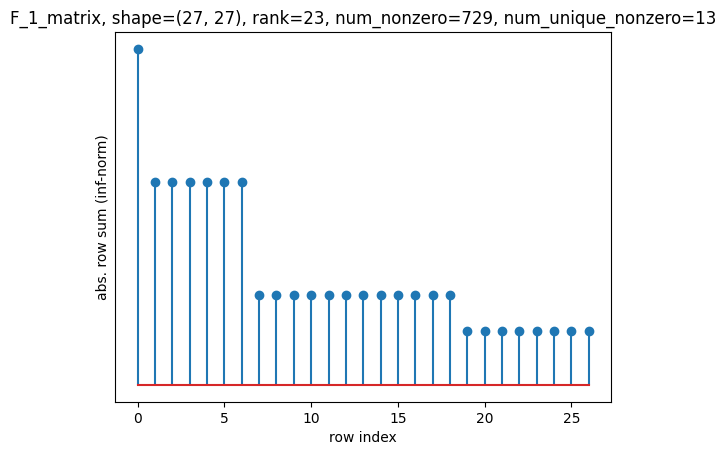

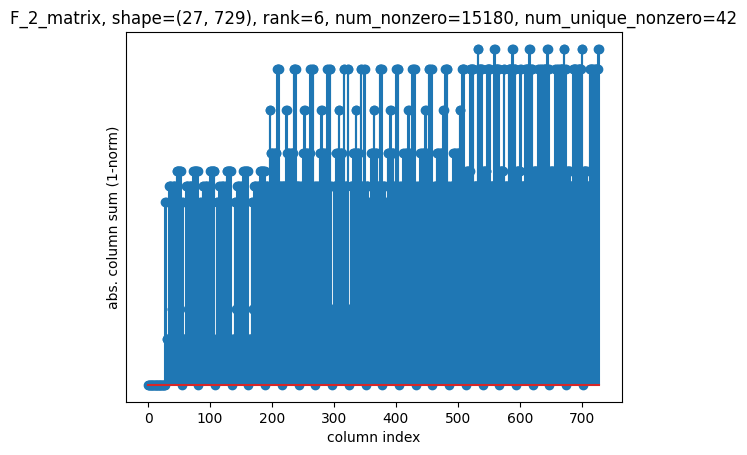

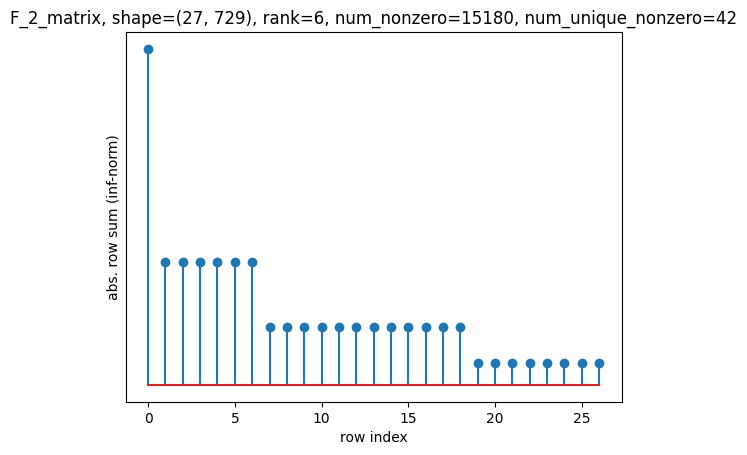

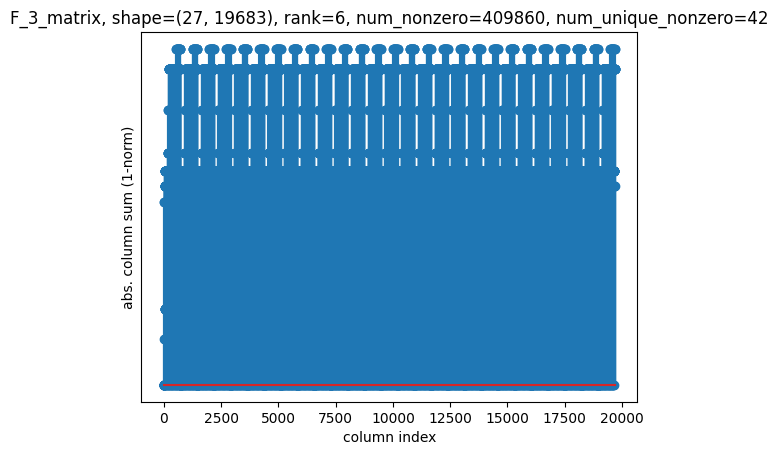

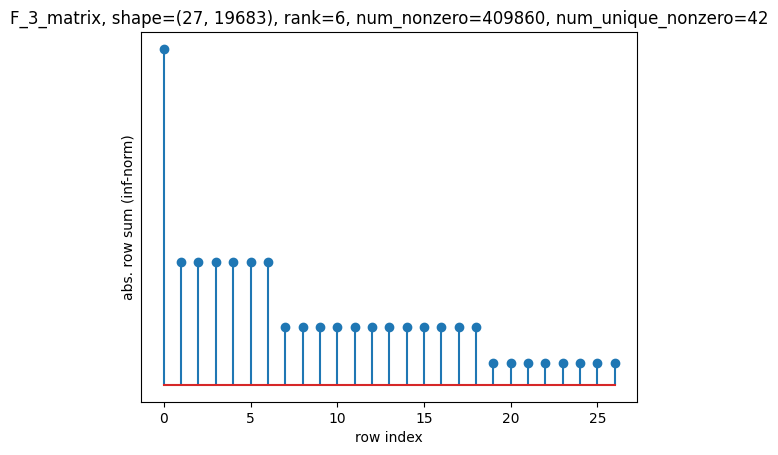

In [11]:
# A.sum(axis=0) # numpy column sum
# A.sum(axis=1) # numpy row sum


for F_matrix_name in F_matrix_var_names:
    F_matrix = locals()[F_matrix_name]

    # column sum
    
    F_abs_col_sum = np.abs(F_matrix).sum(axis=0)
    # # sanity check:
    # print(f"long way: {np.max(F_abs_col_sum)}")
    # print(f"short way: {np.linalg.norm(F_matrix, ord=1)}")
    plt.stem(F_abs_col_sum)
    plt.title(print_matrix_info(F_matrix_name, return_val=True))
    plt.xlabel("column index")
    plt.ylabel("abs. column sum (1-norm)")
    
    # not showing the scale because we haven't multiplied by 1/tau yet.
    plt.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
    plt.show()
    # print("WARNING!!!  These matrices have not been scaled by the tau parameter yet!")
    # print(f"{F_matrix_name} 1-norm (max abs col sum): {np.max(F_abs_col_sum)}")

    # row sum
    F_abs_row_sum = np.abs(F_matrix).sum(axis=1)
    # # sanity check:
    # print(f"long way: {np.max(F_abs_row_sum)}")
    # print(f"short way: {np.linalg.norm(F_matrix, ord=np.inf)}")
    plt.stem(F_abs_row_sum)
    plt.title(print_matrix_info(F_matrix_name, return_val=True))
    plt.xlabel("row index")
    plt.ylabel("abs. row sum (inf-norm)")
    # not showing the scale because we haven't multiplied by 1/tau yet.
    plt.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
    plt.show()
    # print("WARNING!!!  These matrices have not been scaled by the tau parameter yet!")
    # print(f"{F_matrix_name} inf-norm (max abs row sum): {np.max(F_abs_row_sum)}")



In [12]:
tau = sympy.Symbol("tau")

F_1_1norm =  (1/tau)*(np.linalg.norm(F_1_matrix, ord=1))
F_2_1norm =  (1/tau)*(np.linalg.norm(F_2_matrix, ord=1))
F_3_1norm =  (1/tau)*(np.linalg.norm(F_3_matrix, ord=1))

F_1_inf_norm = (1/tau)*(np.linalg.norm(F_1_matrix, ord=np.inf))
F_2_inf_norm =  (1/tau)*(np.linalg.norm(F_2_matrix, ord=np.inf))
F_3_inf_norm =  (1/tau)*(np.linalg.norm(F_3_matrix, ord=np.inf))

F_1_spectral_norm = (1/tau)*(np.linalg.norm(F_1_matrix, ord=2))
F_2_spectral_norm =  (1/tau)*(np.linalg.norm(F_2_matrix, ord=2))
F_3_spectral_norm =  (1/tau)*(np.linalg.norm(F_3_matrix, ord=2))

print(f"F_1_inf_norm: {F_1_inf_norm}")
print(f"F_2_inf_norm: {F_2_inf_norm}")
print(f"F_3_inf_norm: {F_3_inf_norm}\n")

print(f"F_1_1norm: {F_1_1norm}")
print(f"F_2_1norm: {F_2_1norm}")
print(f"F_3_1norm: {F_3_1norm}\n")

print(f"F_1 spectral norm: {F_1_spectral_norm}")
print(f"F_2 spectral norm: {F_2_spectral_norm}")
print(f"F_3 spectral norm: {F_3_spectral_norm}")


tau_val = 0.6
print(f"\nif tau={tau_val}, then...\n")

print(f"if tau={tau_val}, then F_1_inf_norm: {F_1_inf_norm.evalf(subs={tau: tau_val}):0.3f}")
print(f"if tau={tau_val}, then F_2_inf_norm: {F_2_inf_norm.evalf(subs={tau: tau_val}):0.3f}")
print(f"if tau={tau_val}, then F_3_inf_norm: {F_3_inf_norm.evalf(subs={tau: tau_val}):0.3f}\n")


print(f"if tau={tau_val}, then F_1_1norm: {F_1_1norm.evalf(subs={tau: tau_val}):0.3f}")
print(f"if tau={tau_val}, then F_2_1norm: {F_2_1norm.evalf(subs={tau: tau_val}):0.3f}")
print(f"if tau={tau_val}, then F_3_1norm: {F_3_1norm.evalf(subs={tau: tau_val}):0.3f}\n")


print(f"if tau={tau_val}, then F_1 spectral norm: {F_1_spectral_norm.evalf(subs={tau: tau_val}):0.3f}")
print(f"if tau={tau_val}, then F_2 spectral norm: {F_2_spectral_norm.evalf(subs={tau: tau_val}):0.3f}")
print(f"if tau={tau_val}, then F_3 spectral norm: {F_3_spectral_norm.evalf(subs={tau: tau_val}):0.3f}")


F_1_inf_norm: 8.40740740740741/tau
F_2_inf_norm: 565.333333333333/tau
F_3_inf_norm: 7632.0/tau

F_1_1norm: 3.48148148148148/tau
F_2_1norm: 7.33333333333333/tau
F_3_1norm: 3.66666666666667/tau

F_1 spectral norm: 1.83711730708738/tau
F_2 spectral norm: 28.4604989415154/tau
F_3 spectral norm: 73.9425452631974/tau

if tau=0.6, then...

if tau=0.6, then F_1_inf_norm: 14.012
if tau=0.6, then F_2_inf_norm: 942.222
if tau=0.6, then F_3_inf_norm: 12720.000

if tau=0.6, then F_1_1norm: 5.802
if tau=0.6, then F_2_1norm: 12.222
if tau=0.6, then F_3_1norm: 6.111

if tau=0.6, then F_1 spectral norm: 3.062
if tau=0.6, then F_2 spectral norm: 47.434
if tau=0.6, then F_3 spectral norm: 123.238


In [13]:
# # Construct the A matrix

A_dim = nQ + (nQ)**2 + (nQ)**3

print(f"A is {A_dim}x{A_dim}")

A = np.zeros((A_dim,A_dim))
I = np.zeros((nQ,nQ))


#S matrix in this case (only one node) is zero.



rows = slice(0,nQ)
cols = slice(0,nQ)
A[rows, cols] = F_1_matrix

rows = slice(0,nQ)
cols = slice(nQ, nQ + (nQ)**2)
A[rows, cols] = F_2_matrix

rows = slice(0,nQ)
cols = slice(nQ + (nQ)**2, nQ + (nQ)**2 + (nQ)**3)
A[rows, cols] = F_3_matrix


# F_1^[2]
F_1_2 = np.kron(I,F_1_matrix) + np.kron(F_1_matrix,I)
rows = slice(nQ, nQ + (nQ)**2)
cols = slice(nQ, nQ + (nQ)**2)
A[rows, cols] = F_1_2


# F_2^[2]
F_2_2 = np.kron(I,F_2_matrix) + np.kron(F_2_matrix,I)
rows = slice(nQ, nQ + (nQ)**2)
cols = slice(nQ + (nQ)**2, nQ + (nQ)**2 + (nQ)**3)
A[rows, cols] = F_2_2


# F_1^[3]
F_1_3 = np.kron(I,np.kron(I,F_1_matrix))
F_1_3 += np.kron(I,np.kron(I,F_1_matrix))
F_1_3 += np.kron(I,np.kron(F_1_matrix,I))
rows = slice(nQ + (nQ)**2, nQ + (nQ)**2 + (nQ)**3)
cols = slice(nQ + (nQ)**2, nQ + (nQ)**2 + (nQ)**3)
A[rows, cols] = F_1_3



A is 20439x20439


In [14]:

np.savez_compressed("F_2_2_matrix.npz",F_2_2=F_2_2)
np.savez_compressed("F_1_2_matrix.npz",F_1_2=F_1_2)
np.savez_compressed("F_1_3_matrix.npz",F_1_3=F_1_3)

np.savez_compressed("A_matrix.npz", A=A)

print("after writing the A matrix to the `A_matrix.npz` file, you may run the `example_A_norm.py` script for some empirical results.")
print("running some norm calculations directly in a default-sized Jupyter notebook instance crashes.")

after writing the A matrix to the `A_matrix.npz` file, you may run the `example_A_norm.py` script for some empirical results.
running some norm calculations directly in a default-sized Jupyter notebook instance crashes.


In [15]:
# Establishing an upper bound on the spectral norm of A per "Appendix: Bounding the spectral norm of A" 



A_1norm_bound = F_3_1norm + 2*(F_2_1norm) + (6+3*(F_1_1norm))
print(f"A 1-norm bound: {A_1norm_bound}\n")


A_inf_norm_bound = 2 + F_1_inf_norm + F_2_inf_norm + F_3_inf_norm
# 2 is from the inf norm of the S matrix
print(f"A inf-norm bound: {A_inf_norm_bound}\n")


A_spec_norm_bound = (A_1norm_bound*A_inf_norm_bound)**(1/2)
print(f"A spectral norm bound: {A_spec_norm_bound}\n\n")

print("Recall that 0.5 < tau <= 1.0.")
tau_vals = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for tau_val in tau_vals:
    print(f"if tau={tau_val}, then the upper bound on ||A||_2 is: {A_spec_norm_bound.evalf(subs={tau: tau_val})}")



A 1-norm bound: 6 + 28.7777777777778/tau

A inf-norm bound: 2 + 8205.74074074074/tau

A spectral norm bound: ((2 + 8205.74074074074/tau)*(6 + 28.7777777777778/tau))**0.5


Recall that 0.5 < tau <= 1.0.
if tau=0.5, then the upper bound on ||A||_2 is: 1021.35592922173
if tau=0.6, then the upper bound on ||A||_2 is: 859.137978084064
if tau=0.7, then the upper bound on ||A||_2 is: 743.204950911508
if tau=0.8, then the upper bound on ||A||_2 is: 656.201502421196
if tau=0.9, then the upper bound on ||A||_2 is: 588.485714752719
if tau=1.0, then the upper bound on ||A||_2 is: 534.272387026594
